In [116]:
import pandas as pd
import numpy as np

In [117]:
df = pd.read_csv('data/dataproject2025.csv')

In [118]:
df.head()

,Unnamed: 0,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,emp_length,...,purpose,revol_bal,revol_util,sub_grade,target,tax_liens,zip_code,Pct_afro_american,Predictions,Predicted probabilities
0,0,2013,0,39600.0,1379.0,21564.0,16.1,0.0,2.49,2 years,...,home_improvement,4136.0,16.1,B2,0,0.0,782,7.388592,0,0.053051
1,1,2013,0,55000.0,9570.0,16473.0,53.9,0.0,22.87,10+ years,...,debt_consolidation,36638.0,61.2,B2,0,0.0,481,9.745456,0,0.084507
2,2,2013,0,325000.0,53306.0,13901.0,67.1,0.0,18.55,5 years,...,debt_consolidation,29581.0,54.6,A3,0,0.0,945,7.542862,0,0.037206
3,3,2013,0,130000.0,36362.0,3567.0,93.0,0.0,13.03,10+ years,...,debt_consolidation,10805.0,67.0,B3,0,0.0,809,6.598132,0,0.061371
4,4,2013,1,73000.0,24161.0,4853.0,74.7,1.0,23.13,6 years,...,debt_consolidation,27003.0,82.8,D5,1,0.0,802,7.058900,1,0.345896


In [ ]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="Data Report", explorative=True)
profile.to_notebook_iframe()

# Surrogate Model Analysis for Black-Box Model Interpretation

We'll implement surrogate models to interpret the unknown model that generated the Default Probabilities (DP).
The DP column is the `Predicted probabilities` which represents the original model's output.

In [121]:
# Import required libraries for surrogate modeling with TableVectorizer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from skrub import TableVectorizer  # For automated preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

In [122]:
# The target variable for surrogate models is the DP (Predicted probabilities)
target_col = 'Predicted probabilities'
print(f"\nTarget variable (DP): {target_col}")
print(f"DP statistics:")
print(df[target_col].describe())


Target variable (DP): Predicted probabilities
DP statistics:


count    1.086236e+06
mean     1.986501e-01
std      1.187794e-01
min      1.608998e-03
25%      1.070415e-01
50%      1.779001e-01
75%      2.684615e-01
max      7.859512e-01
Name: Predicted probabilities, dtype: float64


In [123]:
# Prepare data using TableVectorizer for automated preprocessing
# TableVectorizer automatically handles different data types (numerical, categorical, text)

# Define columns to exclude from features
exclude_cols = ['Unnamed: 0', 'Predictions', 'Predicted probabilities', 'target']

# Prepare feature matrix (all columns except excluded ones)
feature_cols = [col for col in df.columns if col not in exclude_cols]
X_raw = df[feature_cols].copy()
y = df['Predicted probabilities']  # This is our DP (Default Probability)

In [ ]:
# Clean data for TableVectorizer preprocessing
# Remove rows with missing values completely to ensure clean data
df_clean = df.dropna()  # Remove all rows with any missing values
X_raw_clean = df_clean[feature_cols].copy()
y_clean = df_clean['Predicted probabilities']

# Initialize TableVectorizer with default parameters
vectorizer = TableVectorizer()

In [125]:
# Use data from 2018, 2019, and 2020 as the test set
test_years = [2018, 2019, 2020]
test_indices = X_raw_clean[X_raw_clean['issue_d'].isin(test_years)].index
train_indices = X_raw_clean[~X_raw_clean['issue_d'].isin(test_years)].index

X_train = X_raw_clean.loc[train_indices]
y_train = y_clean.loc[train_indices]
X_test = X_raw_clean.loc[test_indices]
y_test = y_clean.loc[test_indices]

# Fit the TableVectorizer on training data
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

## Surrogate Model 1: Linear Regression
Linear regression will help us understand the linear relationships between features and the default probability.

In [133]:
# Surrogate Model 1: Linear Regression with TableVectorizer preprocessing
linear_model = LinearRegression()
linear_model.fit(X_train_vectorized, y_train)

# Make predictions
y_pred_linear = linear_model.predict(X_test_vectorized)

# Evaluate the linear surrogate model
r2_linear = r2_score(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)

# Feature importance (coefficients) with vectorized feature names
feature_names_vec = vectorizer.get_feature_names_out()
feature_importance_linear = pd.DataFrame({
    'feature': feature_names_vec,
    'coefficient': linear_model.coef_,
    'abs_coefficient': np.abs(linear_model.coef_)
}).sort_values('abs_coefficient', ascending=False)

## Surrogate Model 2: Decision Tree
Decision trees provide interpretable rules and can capture non-linear relationships.

In [134]:
# Surrogate Model 2: Decision Tree with TableVectorizer preprocessing
# Use limited depth for interpretability
tree_model = DecisionTreeRegressor(
    max_depth=6,  # Limit depth for interpretability
    min_samples_split=100,  # Prevent overfitting
    min_samples_leaf=50,
    random_state=42
)

tree_model.fit(X_train_vectorized, y_train)

# Make predictions
y_pred_tree = tree_model.predict(X_test_vectorized)

# Evaluate the tree surrogate model
r2_tree = r2_score(y_test, y_pred_tree)
mse_tree = mean_squared_error(y_test, y_pred_tree)
mae_tree = mean_absolute_error(y_test, y_pred_tree)

# Feature importance from tree with vectorized feature names
feature_names_vec = vectorizer.get_feature_names_out()
feature_importance_tree = pd.DataFrame({
    'feature': feature_names_vec,
    'importance': tree_model.feature_importances_
}).sort_values('importance', ascending=False)


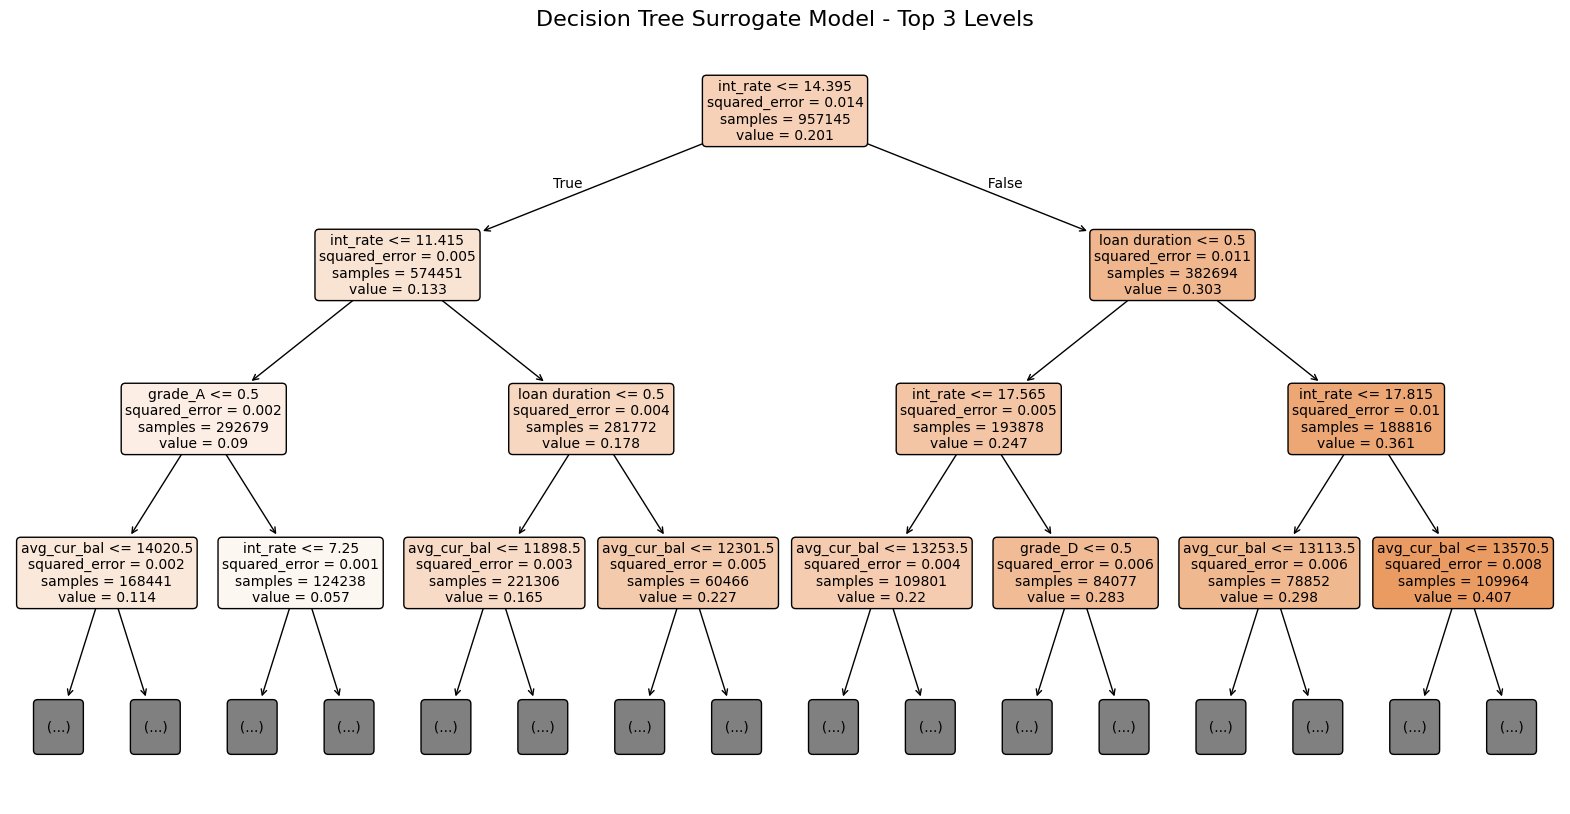

In [135]:
# Visualize the Decision Tree Structure (top levels only)
plt.figure(figsize=(20, 10))
plot_tree(tree_model, 
          feature_names=feature_names_vec,  # Use vectorized feature names
          filled=True, 
          rounded=True, 
          fontsize=10,
          max_depth=3)  # Show only top 3 levels for readability
plt.title("Decision Tree Surrogate Model - Top 3 Levels", fontsize=16)
plt.show()

SURROGATE MODEL COMPARISON (with TableVectorizer):
Linear Regression R²: 0.1753
Decision Tree R²:     0.8103
Original features: 35
Features after TableVectorizer: 128
Feature expansion: 3.7x


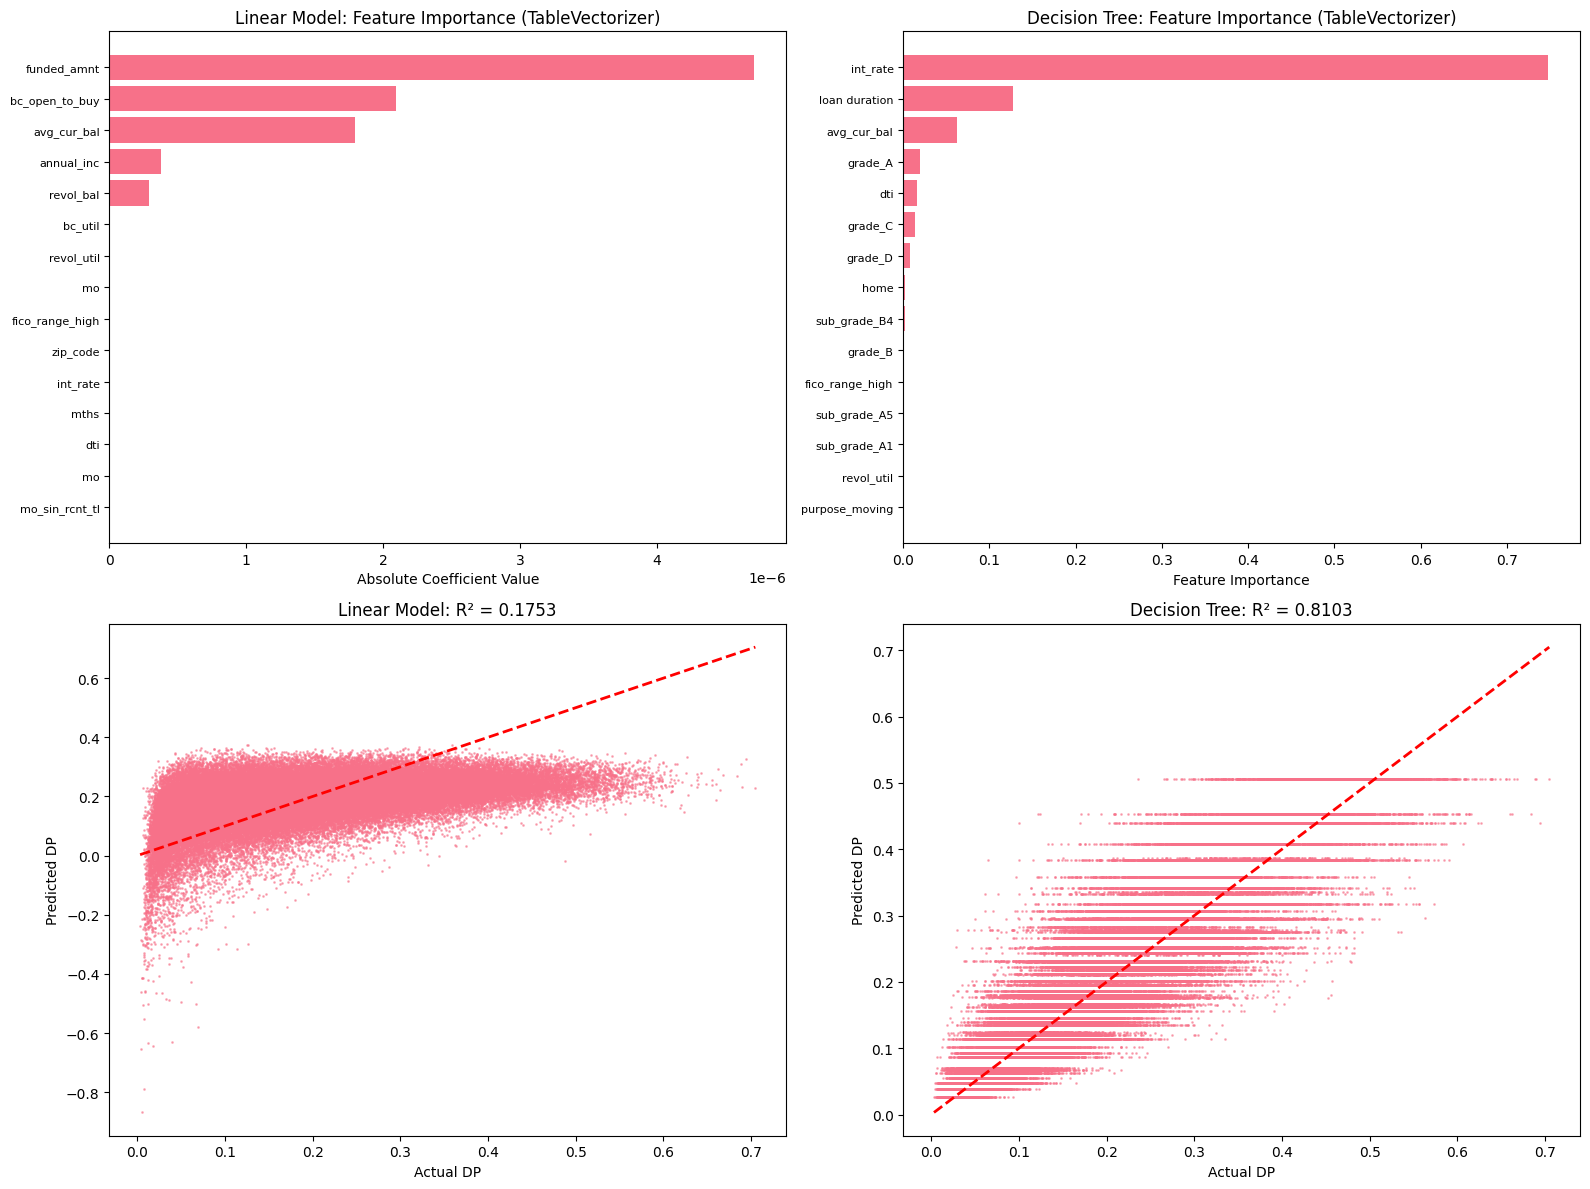


Comparison of Top Features:
------------------------------------------------------------
LINEAR MODEL (Top 10):
  funded_amnt                                  4.71e-06
  bc_open_to_buy                              -2.09e-06
  avg_cur_bal                                 -1.79e-06
  annual_inc                                  -3.80e-07
  revol_bal                                   -2.87e-07
  bc_util                                      3.68e-09
  revol_util                                   3.15e-09
  mo_sin_old_rev_tl_op                         2.53e-09
  fico_range_high                             -1.41e-09
  zip_code                                     1.38e-09

DECISION TREE (Top 10):
  int_rate                                       0.7474
  loan duration                                  0.1268
  avg_cur_bal                                    0.0628
  grade_A                                        0.0197
  dti                                            0.0158
  grade_C             

In [136]:
# Model Comparison and Visualization with TableVectorizer
print("SURROGATE MODEL COMPARISON (with TableVectorizer):")
print("="*60)
print(f"Linear Regression R²: {r2_linear:.4f}")
print(f"Decision Tree R²:     {r2_tree:.4f}")
print("="*60)
print(f"Original features: {X_train.shape[1]}")
print(f"Features after TableVectorizer: {X_train_vectorized.shape[1]}")
print(f"Feature expansion: {X_train_vectorized.shape[1] / X_train.shape[1]:.1f}x")

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Feature Importance Comparison (top 15 features)
top_features = 15
linear_top = feature_importance_linear.head(top_features)
tree_top = feature_importance_tree.head(top_features)

# Linear model coefficients (using absolute values for better visualization)
axes[0, 0].barh(range(len(linear_top)), linear_top['abs_coefficient'])
axes[0, 0].set_yticks(range(len(linear_top)))
axes[0, 0].set_yticklabels([f.split('_')[0] if len(f) > 15 else f for f in linear_top['feature']], fontsize=8)
axes[0, 0].set_xlabel('Absolute Coefficient Value')
axes[0, 0].set_title('Linear Model: Feature Importance (TableVectorizer)')
axes[0, 0].invert_yaxis()

# Tree model importance
axes[0, 1].barh(range(len(tree_top)), tree_top['importance'])
axes[0, 1].set_yticks(range(len(tree_top)))
axes[0, 1].set_yticklabels([f.split('_')[0] if len(f) > 15 else f for f in tree_top['feature']], fontsize=8)
axes[0, 1].set_xlabel('Feature Importance')
axes[0, 1].set_title('Decision Tree: Feature Importance (TableVectorizer)')
axes[0, 1].invert_yaxis()

# 2. Predicted vs Actual scatter plots
axes[1, 0].scatter(y_test, y_pred_linear, alpha=0.5, s=1)
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual DP')
axes[1, 0].set_ylabel('Predicted DP')
axes[1, 0].set_title(f'Linear Model: R² = {r2_linear:.4f}')

axes[1, 1].scatter(y_test, y_pred_tree, alpha=0.5, s=1)
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual DP')
axes[1, 1].set_ylabel('Predicted DP')
axes[1, 1].set_title(f'Decision Tree: R² = {r2_tree:.4f}')

plt.tight_layout()
plt.show()

# Show comparison of most important features
print("\nComparison of Top Features:")
print("-" * 60)
print("LINEAR MODEL (Top 10):")
for i, row in linear_top.head(10).iterrows():
    print(f"  {row['feature'][:40]:40} {row['coefficient']:>12.2e}")

print("\nDECISION TREE (Top 10):")
for i, row in tree_top.head(10).iterrows():
    print(f"  {row['feature'][:40]:40} {row['importance']:>12.4f}")